In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import h5py
import glob
import dxchange
from tqdm import tqdm
import pandas as pd

In [2]:
autoreduce_path  = "/SNS/VENUS/IPTS-35945/shared/autoreduce/mcp/images/"
assert os.path.exists(autoreduce_path)
nexus_path = "/SNS/VENUS/IPTS-35945/nexus/"
assert os.path.exists(nexus_path)

In [3]:
title = "5c"

ob_folder = os.path.join(autoreduce_path, "Run_7817")
ob_nexus = os.path.join(nexus_path, "VENUS_7817.nxs.h5")
ob_frame_number = None

sample_folder = os.path.join(autoreduce_path, "Run_7821")
sample_nexus = os.path.join(nexus_path, "VENUS_7821.nxs.h5")
sample_frame_number = None

# test
assert os.path.exists(ob_folder)
assert os.path.exists(ob_nexus)
assert os.path.exists(sample_folder)
assert os.path.exists(sample_nexus)


In [4]:
def load_list_of_tif(list_of_tiff, dtype=None):
    if dtype is None:
        dtype = np.uint16

    # init array
    first_image = dxchange.read_tiff(list_of_tiff[0])
    size_3d = [len(list_of_tiff), np.shape(first_image)[0], np.shape(first_image)[1]]
    data_3d_array = np.empty(size_3d, dtype=dtype)

    # load stack of tiff
    for _index, _file in enumerate(tqdm(list_of_tiff)):
        _array = dxchange.read_tiff(_file)
        data_3d_array[_index] = _array
    return data_3d_array

def get_proton_charge(nexus):
    with h5py.File(nexus, 'r') as hdf5_data:
        proton_chage = hdf5_data['entry']['proton_charge'][0]/1e12
        return proton_chage

# Goal

We will manually normalize the data using this notebook and compare the output with the data produced by another method

# Load data

In [5]:
# load the stack of images
print(f"Loading stack of ob images at {os.path.join(ob_folder, '*.tiff')}")
list_of_ob_images = glob.glob(os.path.join(ob_folder, "*.tif"))
list_of_ob_images.sort()
print("number of images: ", len(list_of_ob_images))

print(f"Loading stack of sample images at {os.path.join(sample_folder, '*.tiff')}")
list_of_sample_images = glob.glob(os.path.join(sample_folder, "*.tif"))
list_of_sample_images.sort()
print("number of images: ", len(list_of_sample_images))


Loading stack of ob images at /SNS/VENUS/IPTS-35945/shared/autoreduce/mcp/images/Run_7817/*.tiff
number of images:  2782
Loading stack of sample images at /SNS/VENUS/IPTS-35945/shared/autoreduce/mcp/images/Run_7821/*.tiff
number of images:  2782


In [6]:
ob_data = load_list_of_tif(list_of_ob_images)
sample_data = load_list_of_tif(list_of_sample_images)


100%|██████████| 2782/2782 [00:38<00:00, 71.48it/s]


Visualize the data

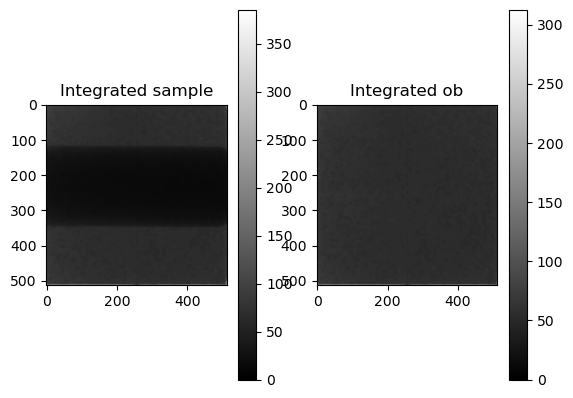

In [7]:
integrated_sample = np.mean(sample_data, axis=0)
integrated_ob = np.mean(ob_data, axis=0)

plt.figure()
plt.subplot(121)
plt.imshow(integrated_sample, cmap='gray')
plt.title("Integrated sample")
plt.colorbar()
plt.subplot(122)
plt.imshow(integrated_ob, cmap='gray')
plt.title("Integrated ob")
plt.colorbar()

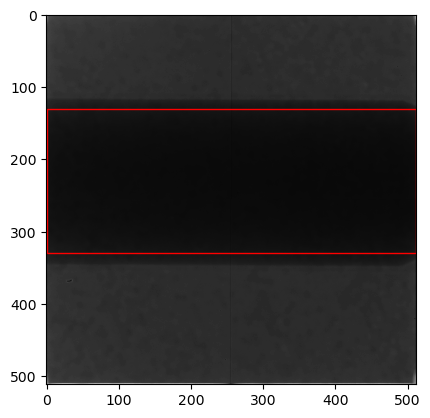

In [8]:
# select region to use

region = {'x0': 0, 'y0': 130, 'width': 512, 'height': 200}

plt.figure()
plt.imshow(integrated_sample, cmap='gray')
# display rectangle
rect = plt.Rectangle((region['x0'], region['y0']), region['width'], region['height'],
                     linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

crop data

In [9]:
sample_data_cropped = [_data[region['y0']:region['y0'] + region['height'], region['x0']:region['x0'] + region['width']] for _data in sample_data]
ob_data_cropped = [_data[region['y0']:region['y0'] + region['height'], region['x0']:region['x0'] + region['width']] for _data in ob_data]

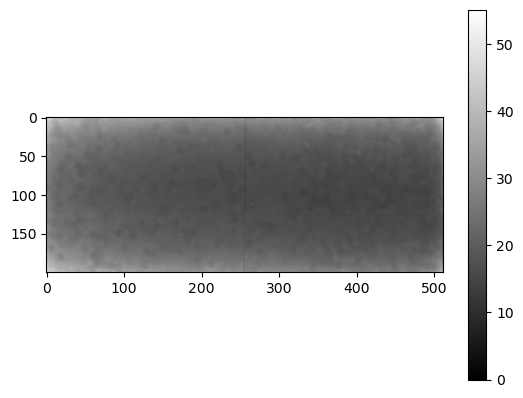

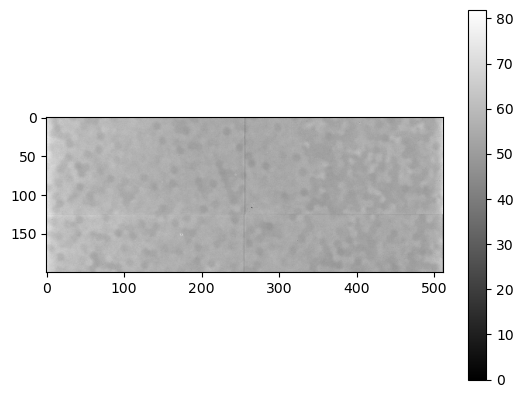

In [10]:
integrated_sample = np.mean(sample_data_cropped, axis=0)
plt.figure()
plt.imshow(integrated_sample, cmap='gray')
plt.colorbar()

integrated_ob = np.mean(ob_data_cropped, axis=0)
plt.figure()
plt.imshow(integrated_ob, cmap='gray')
plt.colorbar()

# 1 sample / ob using number of shutter values for each frame 

retrieve shutter values from shutter file

In [11]:
_list_file = glob.glob(os.path.join(ob_folder, "*_ShutterCount.txt"))
ob_shutter_count_file = _list_file[0]
print(ob_shutter_count_file)

_list_file = glob.glob(os.path.join(sample_folder, "*_ShutterCount.txt"))
sample_shutter_count_file = _list_file[0]
print(sample_shutter_count_file)

/SNS/VENUS/IPTS-35945/shared/autoreduce/mcp/images/Run_7817/Run_7817_20250415_April15_2025_OB_5C_1_9_Ang_min_0005_2380008_ShutterCount.txt
/SNS/VENUS/IPTS-35945/shared/autoreduce/mcp/images/Run_7821/Run_7821_20250416_April15_2025_Ni_5C_1_9_Ang_min_0005_2384013_ShutterCount.txt


In [12]:
with open(ob_shutter_count_file, 'r') as f:
    lines = f.readlines()
    list_shutter_values_ob = []
    for _line in lines[:]:
        _, _value = _line.strip().split("\t")
        if _value == "0":
            break
        list_shutter_values_ob.append(float(_value))

list_shutter_values_ob = [float(_value) for _value in list_shutter_values_ob]

with open(sample_shutter_count_file, 'r') as f:
    lines = f.readlines()
    list_shutter_values_sample = []
    for _line in lines[:]:
        _, _value = _line.strip().split("\t")
        if _value == "0":
            break
        list_shutter_values_sample.append(float(_value))

list_shutter_values_sample = [float(_value) for _value in list_shutter_values_sample]

In [13]:
print(f"{list_shutter_values_sample = }")
print(f"{list_shutter_values_ob = }")

list_shutter_values_sample = [218930.0, 218905.0, 217473.0, 218551.0, 218741.0]
list_shutter_values_ob = [176125.0, 175766.0, 172906.0, 174907.0, 175696.0]


let's figure out the which image belongs to each frame

In [14]:
# _list_file = glob.glob(os.path.join(ob_folder, "*_Spectra.txt"))
# ob_spectra_file = _list_file[0]
# print(f"ob spectra file: {os.path.basename(ob_spectra_file)}")

_list_file = glob.glob(os.path.join(sample_folder, "*_Spectra.txt"))
sample_spectra_file = _list_file[0]
print(f"sample spectra file: {os.path.basename(sample_spectra_file)}")


sample spectra file: Run_7821_20250416_April15_2025_Ni_5C_1_9_Ang_min_0005_2384012_Spectra.txt


In [15]:
# pd_ob = pd.read_csv(ob_spectra_file, sep=",", header=0)
pd_sample = pd.read_csv(sample_spectra_file, sep=",", header=0)

In [16]:
# ob_shutter_time = pd_ob['shutter_time'].values
sample_shutter_time = pd_sample['shutter_time'].values

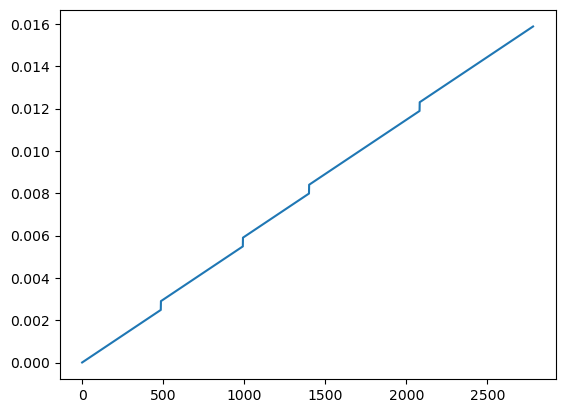

In [17]:
plt.figure()
plt.plot(sample_shutter_time, label="sample")

indexes of jump: [ 485  991 1399 2081]


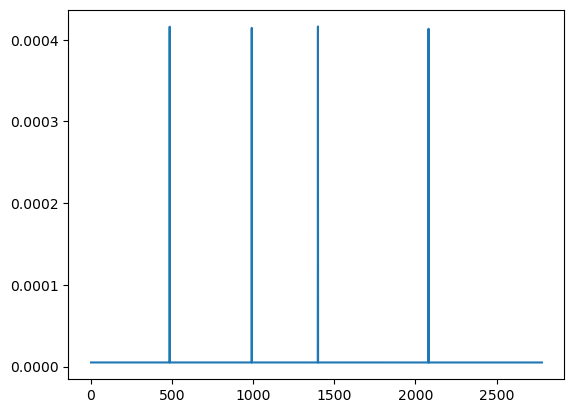

In [18]:
# find the jump in the shutter time
shutter_time_diff = np.diff(sample_shutter_time)
plt.figure()
plt.plot(shutter_time_diff, label="sample")

# find the index of the jump
list_index_jump = np.where(shutter_time_diff > 0.0001)[0]
print(f"indexes of jump: {list_index_jump}")

In [19]:
list_shutter_value_for_each_image = np.zeros_like(list_of_sample_images, dtype=np.float32)
list_ob_shutter_value_for_each_image = np.zeros_like(list_of_ob_images, dtype=np.float32)


In [20]:
list_shutter_value_for_each_image[0: list_index_jump[0]].fill(list_shutter_values_sample[0])
list_ob_shutter_value_for_each_image[0: list_index_jump[0]].fill(list_shutter_values_ob[0])
for _index in range(1, len(list_index_jump)):
    _start = list_index_jump[_index - 1]
    _end = list_index_jump[_index]
    list_shutter_value_for_each_image[_start: _end].fill(list_shutter_values_sample[_index])
    list_ob_shutter_value_for_each_image[_start: _end].fill(list_shutter_values_ob[_index])

list_shutter_value_for_each_image[list_index_jump[-1]:] = list_shutter_values_sample[-1]
list_ob_shutter_value_for_each_image[list_index_jump[-1]:] = list_shutter_values_ob[-1]


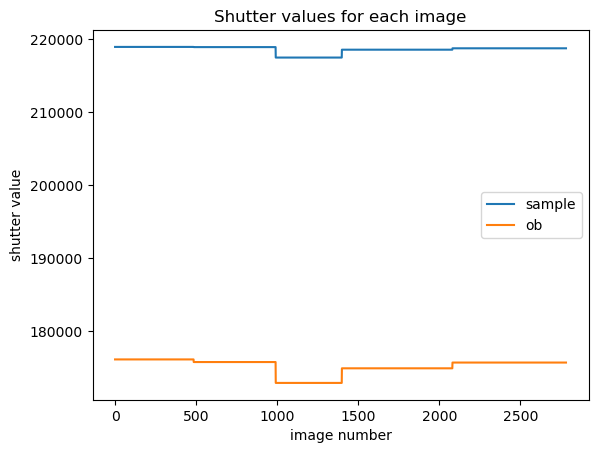

In [21]:
plt.figure()
plt.title("Shutter values for each image")
plt.xlabel("image number")
plt.ylabel("shutter value")
plt.plot(list_shutter_value_for_each_image, label="sample")
plt.plot(list_ob_shutter_value_for_each_image, label="ob")
plt.legend()

normalization

In [22]:
normalized_data_method2 = np.empty_like(sample_data_cropped, dtype=np.float32)
                                             
index = 0                                                                        
for _sample, _ob in zip(sample_data_cropped, ob_data_cropped):
    _sample = _sample.astype(np.float32)
    _ob = _ob.astype(np.float32)

    # using numpy, replace 0 values by NaN
    _sample[_sample == 0] = np.nan
    _ob[_ob == 0] = np.nan 

    # coefficient
    _sample_shutter_value = float(list_shutter_value_for_each_image[index])
    _ob_shutter_value = float(list_ob_shutter_value_for_each_image[index])
       
    _coefficient = _ob_shutter_value / _sample_shutter_value

    # adding proton charge
    _sample_proton_charge = get_proton_charge(sample_nexus)
    _ob_proton_charge = get_proton_charge(ob_nexus)
    _coefficient *= _ob_proton_charge / _sample_proton_charge

    # calculate the ratio
    _ratio = np.divide(_sample, _ob) * _coefficient

    normalized_data_method2[index] = _ratio
    index += 1

In [23]:
# plotting the full profile
profile2_1 = np.nanmean(normalized_data_method2, axis=1)
profile2 = np.nanmean(profile2_1, axis=1)
print(np.shape(profile2))

(2782,)


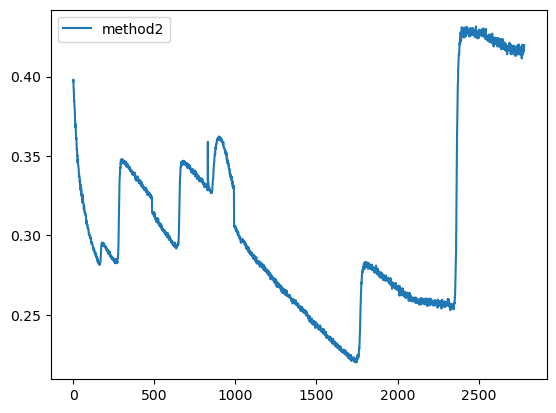

In [24]:
plt.figure(0)
plt.plot(profile2, label='method2')
plt.legend()

# 2 data produced by the same method outside of this notebook

In [41]:
data_path = "/SNS/VENUS/IPTS-35945/shared/jean/images_normalized/Run_7821_normalized"
assert os.path.exists(data_path)

In [42]:
list_tiff = glob.glob(os.path.join(data_path, "*.tif*"))
list_tiff.sort()
print(f"number of images: {len(list_tiff)}")
print(f"Loading stack of images at {os.path.join(data_path, '*.tif')}")

normalized_data = load_list_of_tif(list_tiff, dtype=np.float32)



number of images: 2782
Loading stack of images at /SNS/VENUS/IPTS-35945/shared/jean/images_normalized/Run_7821_normalized/*.tif


100%|██████████| 2782/2782 [00:34<00:00, 80.36it/s]


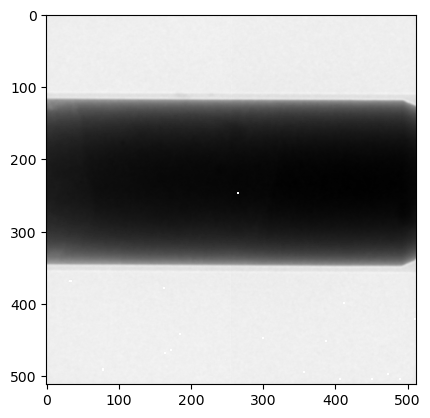

In [43]:
normalized_data = np.transpose(normalized_data, (0, 2, 1))

raw_integrated_normalized_data = np.mean(normalized_data, axis=0)
plt.figure()
plt.imshow(raw_integrated_normalized_data, cmap='gray')

In [44]:
normalized_data_cropped = [_data[region['y0']:region['y0'] + region['height'], region['x0']:region['x0'] + region['width']] for _data in normalized_data]

profile2_1 = np.nanmean(normalized_data_cropped, axis=1)
integrated_normalized = np.nanmean(profile2_1, axis=1)

# Recap

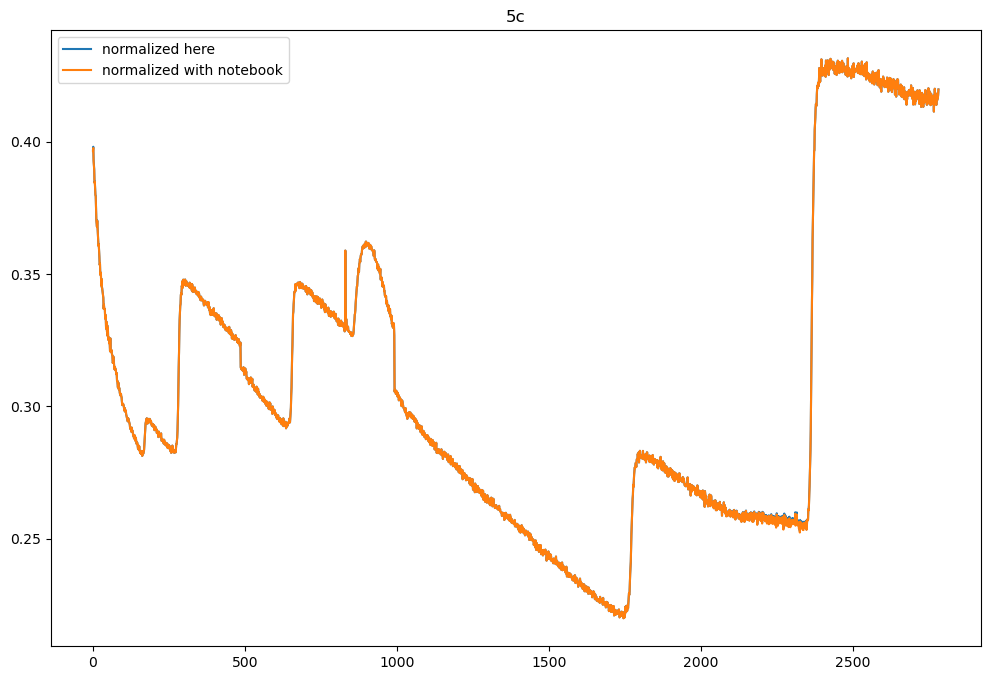

In [45]:
plt.figure(figsize=(12, 8))
plt.title(f"{title}")
plt.plot(profile2, label='normalized here')
plt.plot(integrated_normalized, label='normalized with notebook')
plt.legend()
